In [7]:
import pickle
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error

import torch

In [2]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
tokenizer = AutoTokenizer.from_pretrained("socialmediaie/TRAC2020_ENG_A_bert-base-uncased")
# model = AutoModelForSequenceClassification.from_pretrained(
#     "socialmediaie/TRAC2020_ENG_A_bert-base-uncased", 
#         num_labels=1, 
#     ignore_mismatched_sizes=True
# ).to("cuda")



model = AutoModelForSequenceClassification.from_pretrained(
    './hf_ukraine/run1/checkpoint-65000'
).to("cuda")

2024-04-18 14:21:16.891044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 14:21:17.503080: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib:/usr/local/cuda/lib64::/usr/local/opencv-4.5.5/build/lib:/usr/local/opencv-4.5.5/build/lib
2024-04-18 14:21:17.503135: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib

In [3]:
import pickle        
with open('before_war_doc_toxicity_scores.pkl', 'rb') as f:
    before_war_doc_scores = pickle.load(f)
with open('war_and_after_doc_toxicity_scores.pkl', 'rb') as f:
    war_and_after_doc_scores = pickle.load(f)

with open('before_war_sample.pkl', 'rb') as f:
    before_war_sample = pickle.load(f)
with open('war_and_after_sample.pkl', 'rb') as f:
    war_and_after_sample = pickle.load(f)


In [9]:
war_and_after_shrink = war_and_after_sample.iloc[:800000]
war_and_after_doc_scores = war_and_after_doc_scores[:800000]

with open('war_and_after_shrink.pkl', 'wb') as f:
     pickle.dump(war_and_after_shrink, f)
war_and_after_shrink.shape


(800000, 5)

In [10]:
x_train = before_war_sample['cleaned_text'].tolist()
y_train = before_war_doc_scores
x_test = war_and_after_shrink['cleaned_text'].tolist()
y_test = war_and_after_doc_scores

In [ ]:
with open('x_train_encodings.pkl', 'rb') as f:
    x_train_encodings = pickle.load(f)
with open('x_test_encodings.pkl', 'rb') as f:
    x_test_encodings = pickle.load(f)

# train_encodings_batches[0][


In [6]:
max_length = model.config.max_position_embeddings

def batch_tokenize(texts, tokenizer, batch_size=32, max_length=None):
    # Tokenize all texts at once (adjust if memory constraints are an issue)
    encodings = tokenizer(texts, truncation=True, padding="max_length", max_length=max_length, return_tensors="pt")
    return encodings

x_train_encodings = batch_tokenize(x_train, tokenizer, max_length=max_length)
x_test_encodings = batch_tokenize(x_test, tokenizer, max_length=max_length)


with open('x_train_encodings.pkl', 'wb') as f:
     pickle.dump(x_train_encodings, f)
with open('x_test_encodings.pkl', 'wb') as f:
     pickle.dump(x_test_encodings, f)

In [4]:
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader

max_length = model.config.max_position_embeddings

#try not running in batches and just do something like tokenizer xtrain.

# def batch_tokenize(texts, tokenizer, batch_size=32, max_length=None):
#     # Initialize batch start index
#     batch_start = 0
#     # Initialize container for batched encodings
#     batch_encodings = []
    
#     # Wrap the range with tqdm for a progress bar
#     total_batches = (len(texts) + batch_size - 1) // batch_size  # Compute the total number of batches
#     for batch_start in tqdm(range(0, len(texts), batch_size), total=total_batches, desc="Tokenizing"):
#         # Calculate batch end index
#         batch_end = batch_start + batch_size
#         # Slice the texts for the current batch
#         batch_texts = texts[batch_start:batch_end]
#         # Tokenize the current batch
#         encodings = tokenizer(batch_texts, truncation=True, padding="max_length", max_length=max_length, return_tensors = "pt")
#         # Store the encodings
#         batch_encodings.append(encodings)
    
#     return batch_encodings

# # Tokenize data in batches with progress bar
# train_encodings_batches = batch_tokenize(x_train[:100], tokenizer, batch_size=32, max_length=max_length)
# test_encodings_batches = batch_tokenize(x_test[:100], tokenizer, batch_size=32, max_length=max_length)



class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor([self.labels[idx]], dtype=torch.float)  # Ensure labels are correctly shaped
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset
# train_dataset = CustomDataset(x_train_encodings, y_train)
# test_dataset = CustomDataset(x_test_encodings, y_test)

# # #create for batching the data, which is necessary for training the model efficiently. 
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
# with open('train_dataset.pkl', 'wb') as f:
#      pickle.dump(train_dataset, f)
# with open('test_dataset.pkl', 'wb') as f:
#      pickle.dump(test_dataset, f)
# with open('train_loader.pkl', 'wb') as f:
#      pickle.dump(train_loader, f)
# with open('test_loader.pkl', 'wb') as f:
#      pickle.dump(test_loader, f)


with open('train_dataset.pkl', 'rb') as f:
    train_dataset = pickle.load(f)
with open('test_dataset.pkl', 'rb') as f:
    test_dataset = pickle.load(f)

2024-04-19 15:56:36.571810: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 15:56:37.138157: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib:/usr/local/cuda/lib64::/usr/local/opencv-4.5.5/build/lib:/usr/local/opencv-4.5.5/build/lib
2024-04-19 15:56:37.138213: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib

In [11]:
# x_train_encodings2 = tokenizer(x_train, truncation=True, padding="max_length", max_length=512, return_tensors="pt")
# x_test_encodings2 = tokenizer(x_test[:100], truncation=True, padding="max_length", max_length=512, return_tensors="pt")


In [ ]:
for i, x in enumerate(x_train_encodings2):
    x['labels'] = float(torch.tensor(y_train[i]))

for i, x in enumerate(x_test_encodings2):
    x['labels'] = float(torch.tensor(y_test[i]))

#KEEP FOR LABELS, but maybe ignore other cells above

for i, x in enumerate(x_train_encodings):
    x['labels'] = float(torch.tensor(y_train[i]))

for i, x in enumerate(x_test_encodings):
    x['labels'] = float(torch.tensor(y_test[i]))

In [5]:
#https://towardsdatascience.com/linear-regression-with-hugging-face-3883fe729324
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error

num_epochs=3

#compute the metrics for regression
def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)
    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "smape": smape}


# Specifiy the arguments for the trainer  
training_args = TrainingArguments(
    fp16=True,
    output_dir ='./hf_ukraine/run1',          
    num_train_epochs = num_epochs,     
    per_device_train_batch_size = 8,  
    per_device_eval_batch_size = 8,   
    seed=42, 
    # weight_decay = 0.01,               
    # learning_rate = 2e-5,
    logging_dir = './logs/run1',            
    save_total_limit = 10,
    #load_best_model_at_end = True,     
    # metric_for_best_model = 'mse',    
    evaluation_strategy = "epoch",
    # save_strategy = "epoch",
) 
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)


# Call the Trainer
trainer = Trainer(
    model = model,                         
    args = training_args,                  
    train_dataset = train_dataset,         
    eval_dataset = test_dataset, 
    compute_metrics = compute_metrics_for_regression,     
)


/home/mrtcloud-8/miniconda3/envs/hf_38_john/lib/python3.8/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [9]:
# Train the model
trainer.train()


/tmp/ipykernel_139765/2833856379.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
1,0.001000,0.044180,0.044180,0.210189,0.116044,-3.617922,112.277100
2,0.000600,0.019634,0.019634,0.140120,0.084241,-1.052238,113.381690
3,0.000300,0.017394,0.017394,0.131886,0.080897,-0.818122,115.631120


/tmp/ipykernel_139765/2833856379.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_139765/2833856379.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_139765/2833856379.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_139765/2833856379.py:41: UserWarning: To co

TrainOutput(global_step=65361, training_loss=0.0010700119822796537, metrics={'train_runtime': 19728.2798, 'train_samples_per_second': 26.504, 'train_steps_per_second': 3.313, 'total_flos': 1.37573220956885e+17, 'train_loss': 0.0010700119822796537, 'epoch': 3.0})

In [8]:
# Call the summary
trainer.evaluate()

/tmp/ipykernel_8710/776908323.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.01722853071987629,
 'eval_mse': 0.01722853071987629,
 'eval_rmse': 0.13125750422477722,
 'eval_mae': 0.08046024292707443,
 'eval_r2': -0.8008329840570281,
 'eval_smape': 115.61356,
 'eval_runtime': 3575.2458,
 'eval_samples_per_second': 223.761,
 'eval_steps_per_second': 27.97}

/tmp/ipykernel_8710/2373867126.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('winter')


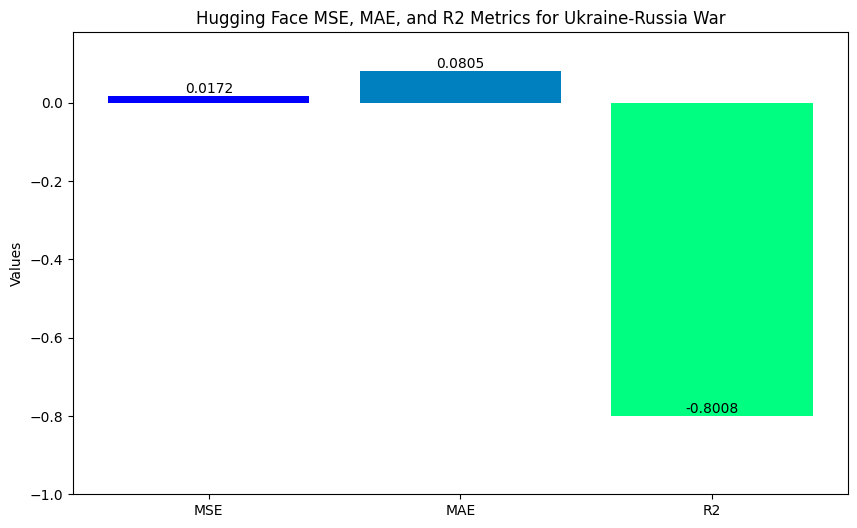

In [18]:
#visualize the results 
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
cmap = get_cmap('winter')
colors = cmap(np.linspace(0, 1, 3))
#extract results
results = {
    'eval_mse': 0.01722853071987629,
    'eval_mae': 0.08046024292707443,
    'eval_r2': -0.8008329840570281
}
#plot
metrics = ['MSE', 'MAE', 'R2']
values = [results['eval_mse'], results['eval_mae'], results['eval_r2']]

# Create a bar chart
plt.figure(figsize=(10, 6))  # Set the figure size
bars = plt.bar(metrics, values, color=[colors[0], colors[1], colors[2]])  

# Add titles and labels
plt.title('Hugging Face MSE, MAE, and R2 Metrics for Ukraine-Russia War')
plt.ylabel('Values')
plt.ylim(min(min(values) - 0.1, -1), max(values) + 0.1)  # Set y-limits to make R2 value clear

# Adding data labels
for bar in bars:
    yval = bar.get_height()  # Get the height of the bar (value of the metric)
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4),  # Position the text in the middle of the bar
             verticalalignment='bottom' if yval < 0 else 'bottom',  # Adjust alignment for negative values
             ha='center')  # Horizontal alignment is center


# Display the plot
plt.show()